<a href="https://colab.research.google.com/github/rjenez/W266-final-project/blob/main/notebooks/Model_Error_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Show Errors of a particular model.
**Author:*** Ricardo Jenez heavily modified from examples in HuggingFace
**Description:** NLP code to detect plagiarism in code.

## Setup

In [1]:
%%capture
!pip3 install transformers
!pip3 install sentence_transformers
!pip3 install imbalanced-learn
!pip3 install datasets
#!pip3 install wandb

In [24]:
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import torch
import datasets
import transformers
import pandas as pd
import numpy as np
from transformers import BertTokenizer, \
BertForSequenceClassification, Trainer, TrainingArguments,EvalPrediction, \
AutoTokenizer,  AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
#import wandb
import random
import datetime
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, \
precision_score, recall_score, f1_score, confusion_matrix, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import pprint
import matplotlib.pyplot as plt


In [3]:
# Set parameters
token_max_length = 512
train_batch_size = 2 # 1 for 4096
model_location = "gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/*"
model_type = "bert-large-uncased-whole-word-masking"

In [4]:
!mkdir saved_model

mkdir: cannot create directory ‘saved_model’: File exists


In [5]:
!gsutil cp -R $model_location saved_model

Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/config.json...
Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/optimizer.pt...
Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/pytorch_model.bin...
Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/rng_state.pth...
/ [4 files][  3.8 GiB/  3.8 GiB]  137.7 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/scaler.pt...
Copying gs://w266finalproject/bert-large-uncased-whole-word-masking03282022_011556_512/scheduler.pt...
Copying gs://w266finalproject/bert-large-uncase

In [6]:
!ls saved_model

config.json   pytorch_model.bin  scaler.pt     trainer_state.json
optimizer.pt  rng_state.pth	 scheduler.pt  training_args.bin


In [7]:
# load model and tokenizer and define length of the text sequence
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSequenceClassification.from_pretrained("./saved_model",
                num_labels = 2,
                cache_dir='data',
                return_dict=True).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_type, 
                                          max_length = 512,
                                          cache_dir='data',)

In [8]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = "saved",
    num_train_epochs = 4,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 32,    
    per_device_eval_batch_size= 16,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 4,
    learning_rate = 1e-5,
    fp16 = True,
    logging_dir='logs',
    dataloader_num_workers = 0,
#    run_name = 'bigbird_classification_1e5'
)
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    # train_dataset=train_data,
    # eval_dataset=valid_data
)

Using amp half precision backend


In [10]:
#!gsutil cp gs://w266finalproject/plagA20162017.tar plag2.tar
!gsutil cp gs://w266finalproject/plag2.tar plag2.tar
!tar xvf plag2.tar
!ls -l

!mv train2.csv train.csv
!mv test2.csv test.csv

test_df = pd.read_csv("test.csv")
oversample = RandomOverSampler(sampling_strategy='minority',random_state=1234)
test_over, y_test_over = oversample.fit_resample(test_df, test_df.plagiarized)
print(test_over.plagiarized.value_counts())
test_data = datasets.Dataset.from_pandas(test_over)
def tokenization(batched_text):
    return tokenizer(batched_text['source0'],batched_text['source1'], padding = 'max_length', truncation=True, max_length = 512)
test_data = test_data.map(tokenization, batched = True, batch_size = 256)
test_data = test_data.map(lambda examples: {'label': examples['plagiarized']}, batched=True)
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])

Copying gs://w266finalproject/plag2.tar...
- [1 files][ 77.8 MiB/ 77.8 MiB]                                                
Operation completed over 1 objects/77.8 MiB.                                     
alldata2.csv
groundtruth2.csv
test2.csv
train2.csv
total 237856
-rw-r--r-- 1  501 staff  1114619 Mar 16 08:22 alldata2.csv
drwxr-xr-x 2 root root      4096 Apr  5 20:44 data
-rw-r--r-- 1  501 staff   203396 Mar 16 08:19 groundtruth2.csv
-rw-r--r-- 1 root root  81619968 Apr  5 22:15 plag2.tar
drwxr-xr-x 1 root root      4096 Mar 23 14:22 sample_data
drwxr-xr-x 2 root root      4096 Apr  5 20:44 saved
drwxr-xr-x 2 root root      4096 Apr  5 22:15 saved_model
-rw-r--r-- 1  501 staff 15819857 Mar 16 08:22 test2.csv
-rw-r--r-- 1  501 staff 15819857 Mar 16 08:22 test.csv
-rw-r--r-- 1  501 staff 64478135 Mar 16 08:22 train2.csv
-rw-r--r-- 1  501 staff 64478135 Mar 16 08:22 train.csv
0    3294
1    3294
Name: plagiarized, dtype: int64


  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [11]:
predictions = trainer.predict(test_data)
pprint.pprint(predictions.metrics)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: filename0, filename1, source0, source1, percent, percent0, percent1, lines, plagiarized. If filename0, filename1, source0, source1, percent, percent0, percent1, lines, plagiarized are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6588
  Batch size = 16


{'test_accuracy': 0.810261080752884,
 'test_f1': 0.8064416227934345,
 'test_loss': 0.5590591430664062,
 'test_precision': 0.8230088495575221,
 'test_recall': 0.7905282331511839,
 'test_runtime': 77.4995,
 'test_samples_per_second': 85.007,
 'test_steps_per_second': 5.316}


In [12]:
preds = np.argmax(predictions.predictions, axis=-1)
print(preds)

[0 1 0 ... 0 1 1]


In [13]:

print(confusion_matrix(preds, y_test_over))

tn, fp, fn, tp = confusion_matrix(preds, y_test_over).ravel()
print(tn,fp,fn,tp)




[[2734  690]
 [ 560 2604]]
2734 690 560 2604


In [43]:
# Data to plot precision - recall curve

precision_c, recall_c, thresholds = precision_recall_curve(y_test_over, preds)


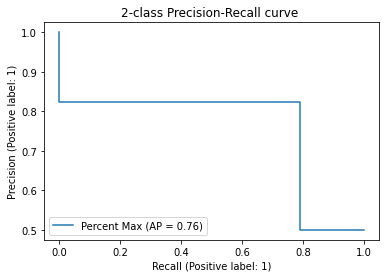

In [44]:
  display = PrecisionRecallDisplay.from_predictions(y_test_over, preds, name="Percent Max")
  _ = display.ax_.set_title("2-class Precision-Recall curve ")
  plt.show()
# plt.plot(recall, precision)
# plt.show()

In [46]:
  # Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall_c, precision_c)
print(f'AUCpr = {auc_precision_recall}')

accuracy = accuracy_score(y_true=y_test_over, y_pred=preds)
print(f'accuracy = {accuracy}')

precision = precision_score(y_true=y_test_over, y_pred=preds)
print(f'precision = {precision}')

recall = recall_score(y_true=y_test_over, y_pred=preds)
print(f'recall={recall}')

f1 = f1_score(y_true=y_test_over, y_pred=preds)
print(f'f1={f1}')

AUCpr = 0.859136483066557
accuracy = 0.810261080752884
precision = 0.8230088495575221
recall=0.7905282331511839
f1=0.8064416227934345


In [16]:

sourcefalsepos = test_over[np.logical_and(preds == 1,predictions.label_ids==0)][['percent','label','plagiarized','lines','filename0','filename1','source0','source1']]
sourcefalsepos.sort_values(by=['percent'])

,percent,label,plagiarized,lines,filename0,filename1,source0,source1
2447,5,5,0,3,A2016/Z4/Z4/student8774,A2016/Z4/Z4/student2254,"#include <stdio.h>\n\nvoid dbr(char *p,char *k...",#include <stdio.h>\n#include <math.h>\n#define...
84,7,7,0,17,A2016/Z4/Z1/student5581,A2016/Z4/Z1/student9823,#include<stdio.h>\n#include<ctype.h>\n\n/*funk...,"#include <stdio.h>\n\nvoid unesi(char niz[], i..."
2958,7,7,0,12,A2016/Z5/Z3/student6956,A2016/Z5/Z3/student8923,#include <stdio.h>\n#include <string.h>\n#defi...,#include <stdio.h>\n#include <string.h>\n#defi...
2983,9,9,0,21,A2016/Z4/Z3/student6877,A2016/Z4/Z3/student6631,#include <stdio.h>\nint slovo(char c){\n\tif((...,#include <stdio.h>\n#include <math.h>\n\nint d...
147,9,9,0,21,A2016/Z5/Z3/student5378,A2016/Z5/Z3/student6548,#include <stdio.h>\n#include <string.h>\n#defi...,#include <stdio.h>\n#include <string.h>\n#defi...
...,...,...,...,...,...,...,...,...
2069,99,99,0,136,A2016/Z1/Z1/student2886,A2016/Z1/Z1/student2197,#include <stdio.h>\n\nint main() {\ndouble PPI...,#include <stdio.h>\n\nint main() {\ndouble PPI...
2077,99,99,0,130,A2016/Z4/Z2/student2351,A2016/Z4/Z2/student7180,#include <stdio.h>\n\nvoid sortiranje(int *sor...,#include <stdio.h>\n\nvoid sortiranje(int *sor...
2082,99,99,0,89,A2016/Z5/Z1/student8004,A2016/Z5/Z1/student5468,#include <stdio.h>\n#include <string.h>\n#defi...,#include <stdio.h>\n#include <string.h>\n#defi...
1924,99,99,0,34,A2016/Z1/Z4/student6547,A2016/Z1/Z4/student8317,"#include <stdio.h>\n\nint main() {\n\tint n=0,...","#include <stdio.h>\n\nint main() {\n\tint n=0,..."


In [17]:
pp = pprint.PrettyPrinter(depth=6,width=200)

In [18]:
sourcefalseneg = test_over[np.logical_and(preds == 0,predictions.label_ids==1)][['percent','label','plagiarized','lines','filename0','filename1','source0','source1']]
sourcefalseneg.sort_values(by=['percent'], ascending=False)

,percent,label,plagiarized,lines,filename0,filename1,source0,source1
3995,99,99,1,32,A2016/Z1/Z4/student6054,A2016/Z1/Z4/student7341,"#include <stdio.h>\n\nint main() {\n\tint red,...","#include <stdio.h>\n\nint main() {\n\tint n, i..."
3781,99,99,1,32,A2016/Z1/Z4/student6054,A2016/Z1/Z4/student7341,"#include <stdio.h>\n\nint main() {\n\tint red,...","#include <stdio.h>\n\nint main() {\n\tint n, i..."
5252,99,99,1,136,A2016/Z1/Z1/student5512,A2016/Z1/Z1/student4852,"#include <stdio.h>\nint main() {\n\tdouble Tb,...","#include <stdio.h>\nint main() {\n\tdouble BT,..."
5956,99,99,1,24,A2016/Z1/Z4/student2939,A2016/Z1/Z4/student5649,"#include <stdio.h>\nint main() {\n\tint i,j,n;...","#include <stdio.h>\n\nint main() {\n\tint n, j..."
3582,99,99,1,24,A2016/Z1/Z4/student2939,A2016/Z1/Z4/student5649,"#include <stdio.h>\nint main() {\n\tint i,j,n;...","#include <stdio.h>\n\nint main() {\n\tint n, j..."
...,...,...,...,...,...,...,...,...
2275,17,17,1,49,A2016/Z5/Z3/student4082,A2016/Z5/Z3/student5378,#include <stdio.h>\n#include<string.h>\n#defin...,#include <stdio.h>\n#include <string.h>\n#defi...
5227,17,17,1,49,A2016/Z5/Z3/student4082,A2016/Z5/Z3/student5378,#include <stdio.h>\n#include<string.h>\n#defin...,#include <stdio.h>\n#include <string.h>\n#defi...
4428,17,17,1,49,A2016/Z5/Z3/student4082,A2016/Z5/Z3/student5378,#include <stdio.h>\n#include<string.h>\n#defin...,#include <stdio.h>\n#include <string.h>\n#defi...
6485,17,17,1,49,A2016/Z5/Z3/student4082,A2016/Z5/Z3/student5378,#include <stdio.h>\n#include<string.h>\n#defin...,#include <stdio.h>\n#include <string.h>\n#defi...


In [19]:
sourcetruepos = test_over[np.logical_and(preds == 1,predictions.label_ids==1)][['percent','label','plagiarized','lines','filename0','filename1','source0','source1']]
sourcetruepos.sort_values(by=['percent'], ascending=False)

,percent,label,plagiarized,lines,filename0,filename1,source0,source1
4954,99,99,1,82,A2016/Z3/Z3/student3567,A2016/Z3/Z3/student2526,#include <stdio.h>\n\nint main() {\n\tint matr...,#include <stdio.h>\n\n\t\nint main() {\n\tint ...
3829,99,99,1,41,A2016/Z1/Z3/student5378,A2016/Z1/Z3/student9538,#include <stdio.h>\n#include <stdlib.h>\n#incl...,#include <stdio.h>\n#include <stdlib.h>\n#incl...
6010,99,99,1,47,A2016/Z1/Z3/student6776,A2016/Z1/Z3/student8357,#include <stdio.h>\n\nint main() {\n\tfloat B=...,#include <stdio.h>\n#include <math.h>\n\nint m...
6028,99,99,1,75,A2016/Z1/Z3/student1915,A2016/Z1/Z3/student4959,#include <stdio.h>\n#include <ctype.h>\nint ma...,#include <stdio.h>\n#include <ctype.h>\nint ma...
3864,99,99,1,205,A2016/Z5/Z1/student4471,A2016/Z5/Z1/student5915,#include <stdio.h>\n#include <string.h>\n\nint...,#include <stdio.h>\n#include <string.h>\n\nint...
...,...,...,...,...,...,...,...,...
4794,19,19,1,15,A2016/Z5/Z1/student5378,A2016/Z5/Z1/student8357,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#define epsilon 0.0001\n#i...
4557,19,19,1,15,A2016/Z5/Z1/student5378,A2016/Z5/Z1/student8357,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#define epsilon 0.0001\n#i...
5336,19,19,1,15,A2016/Z5/Z1/student5378,A2016/Z5/Z1/student8357,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#define epsilon 0.0001\n#i...
1984,19,19,1,15,A2016/Z5/Z1/student5378,A2016/Z5/Z1/student8357,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#define epsilon 0.0001\n#i...


In [20]:

sourcetrueneg = test_over[np.logical_and(preds == 0,predictions.label_ids==0)][['percent','label','plagiarized','lines','filename0','filename1','source0','source1']]
sourcetrueneg.sort_values(by=['percent'], ascending=False)

,percent,label,plagiarized,lines,filename0,filename1,source0,source1
2097,99,99,0,71,A2016/Z4/Z2/student5957,A2016/Z4/Z2/student6550,"#include <stdio.h>\n\nvoid unesi(char niz[], i...","#include <stdio.h>\n\nvoid unesi(char niz[], i..."
2711,99,99,0,23,A2016/Z2/Z2/student4473,A2016/Z2/Z2/student6534,#include <stdio.h>\n#include <stdlib.h>\n#defi...,#include <stdio.h>\n#include <stdlib.h>\n#defi...
3096,99,99,0,149,A2016/Z5/Z1/student7125,A2016/Z5/Z1/student2254,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#include <string.h>\n#incl...
1909,99,99,0,120,A2016/Z1/Z1/student8393,A2016/Z1/Z1/student3288,#include <stdio.h>\n\nint main() {\n\tdouble p...,#include <stdio.h>\n\nint main() {\n\tdouble p...
496,99,99,0,35,A2016/Z2/Z3/student9318,A2016/Z2/Z3/student8665,#include <stdio.h>\n\nint main()\n{\n\tint i=0...,#include <stdio.h>\n\nint main()\n{\n\tint i=0...
...,...,...,...,...,...,...,...,...
1034,2,2,0,3,A2016/Z5/Z3/student7457,A2016/Z5/Z3/student1833,#include <stdio.h>\n#include <string.h>\n#defi...,#include <stdio.h>\n#include <string.h>\n#defi...
2743,2,2,0,9,A2016/Z5/Z2/student3219,A2016/Z5/Z2/student2068,#include <stdio.h>\n#include <string.h>\n\nint...,#include <stdio.h>\n#include <stdlib.h>\n#incl...
1829,2,2,0,3,A2016/Z5/Z3/student5284,A2016/Z5/Z3/student7697,#include <stdio.h>\n#include <string.h>\n#incl...,#include <stdio.h>\n#include <string.h>\n#defi...
289,2,2,0,11,A2016/Z5/Z2/student6369,A2016/Z5/Z2/student3841,#include <stdio.h>\n#include <string.h>\n\nstr...,#include <stdio.h>\n#include <stdlib.h>\n#incl...
